In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, interpolate, stats

## The following is needed to export text correctly for Illustrator ##
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

In [5]:
sigalpha = 0.05

#### Functions

In [6]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [7]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

#### Load Zap_Zip-log_exp to get metadata for experiments

In [8]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}
c_vermillion = (213/255, 94/255, 0/255)
c_bgreen = (0/255, 158/255, 115/255)
c_skyblue = (86/255, 180/255, 233/255)

### Load subjects list from .json file

In [10]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [11]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
        print('')

MOs_superficial

 521885
Experiment type: electrical stimulation

 521886
Experiment type: electrical stimulation

 521887
Experiment type: electrical stimulation

 543393
Experiment type: electrical stimulation

 543394
Experiment type: electrical stimulation

 575102
Experiment type: electrical and sensory stimulation

 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation

 551399
Experiment type: electrical stimulation

 551397
Experiment type: electrical and sensory stimulation

 569062
Experiment type: electrical and sensory stimulation

 569068
Experiment type: electrical and sensory stimulation

 569069
Experiment type: electrical and sensory stimulation

 569064
Experiment type: electrical and sensory stimulation

 569073
Experiment type: electrical and sensory stimulation

 571619
Experiment type: electrical stimulation

 569070
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: el

In [12]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

### Load eeg data and gather stim-evoked traces

In [13]:
## parameters ##
chtrials = 'all' # choose: 'resting', 'running', or 'all'
apply_car = True
test_states = ['awake', 'anesthetized']

In [14]:
start = time.time()
num_good_chs = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')
        
        ## Load stim log and running signal ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
    
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        
        ## Get evoked traces ##
        EEG_traces = {}
        for statei in test_states:
            sweeps = mdata['states'][statei]
            if sweeps:
                state_event_inds = []
                for sweepi in sweeps:
                    eventinds = get_stim_event_inds(stim_log, 'biphasic', str(PCI_stim_amp), sweepi, trials=chtrials)
                    if len(eventinds) == 0:
                        continue
                    state_event_inds.append(eventinds)
                if len(state_event_inds) == 0:
                    continue
                state_event_inds = np.concatenate(state_event_inds)
                
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, state_event_inds]
                
                ## Apply common avg ##
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                
                EEG_traces[statei] = [EEG_event_timestamps, event_traces]
            
        mdata['EEG_traces'] = EEG_traces
        mdata['good_chs'] = GOOD_CHS
        num_good_chs.append(len(GOOD_CHS))

        del all_EEG_traces
        del EEG_event_timestamps
        del stim_log
    print('')
end = time.time()
print('Time to load all subjects: {:.2f} mins'.format((end-start)/60))
num_good_chs = np.array(num_good_chs)

MOs_superficial
 521885
 521886
 521887
 543393
 543394
 575102
 571619

MOs_deep
 546655
 551399
 551397
 569062
 569068
 569069
 569064
 569073
 571619
 569070

SSp_superficial
 571620
 586466
 590479
 590480
 599017

SSp_deep
 569073
 569072
 571620
 586466
 586468
 590479
 590480
 599017

Time to load all subjects: 5.70 mins


In [15]:
print('Mean number of good chs: {:.1f}'.format(np.mean(num_good_chs)))
print('STD: {:.1f}'.format(np.std(num_good_chs)))
print('Min number of good chs: {:d}'.format(np.min(num_good_chs)))
print('Max number of good chs: {:d}'.format(np.max(num_good_chs)))

Mean number of good chs: 23.4
STD: 4.4
Min number of good chs: 17
Max number of good chs: 30


### Plot fig 1C (the array plot with an inset)

Plot awake state only, with all chs (bad = gray), and include the biphasic pulse as an inset

<IPython.core.display.Javascript object>


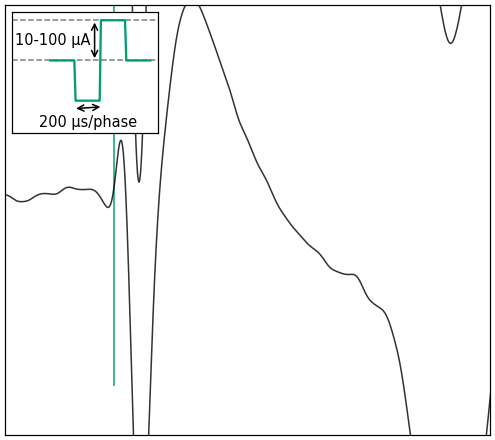

In [16]:
exmouse = '571619'
exgroup = 'MOs_deep'
statei = 'awake'
plwin = [-0.2, 0.8]
xmult = 1.2
ymult = 150 # 250 for VEPs: 100
bregma_ann = {'xycoords': 'data', 'textcoords': 'data', 'arrowprops': dict(arrowstyle='<-', lw=1)}

## Create stim wave for inset ##
xvals = np.arange(-0.2, 0.6, 0.01)
yvals = np.zeros_like(xvals)
yvals[np.nonzero((xvals > 0) & (xvals <= 0.2))[0]] = -1
yvals[np.nonzero((xvals > 0.2) & (xvals <= 0.4))[0]] = 1

EEG_traces = multi_sub_dict[exgroup][exmouse]['EEG_traces']

fig, ax = plt.subplots(figsize=(4.5, 4), constrained_layout=True)

timex = EEG_traces[statei][0]
traces = np.mean(EEG_traces[statei][1], axis=2)
pinds = np.nonzero((timex >= plwin[0]) & (timex <= plwin[1]))[0]

for chi in range(traces.shape[1]):
    if chi in multi_sub_dict[exgroup][exmouse]['good_chs']:
        chcolor = 'k'
    else:
        chcolor = 'darkgray'
    if chi == 0:
        llabel = statei
    else:
        llabel = None
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color=c_bgreen, linewidth=1.2, alpha=0.8, label=None)
    ax.plot(
        timex[pinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        traces[pinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        color=chcolor, linewidth=1.0, alpha=0.8, label=llabel
    )

    if chi == 0:
        mx = timex[0] + EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * 0.85
        my = EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## Scale bar ##
x_len = .5 # x scale bar length in s
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx+x_len/2,my-y_len*2.25), xycoords='data', ha='center', va='bottom')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx-x_len/3,my-y_len/2), xycoords='data', ha='right', va='center')

## Add symbols for stim, NPXs, and bregma ##
ax.annotate('A', xy=(0,0), xytext=(0,70), ha='center', va='bottom', **bregma_ann)
ax.annotate('P', xy=(0,0), xytext=(0,-70), ha='center', va='top', **bregma_ann)
ax.annotate('L', xy=(0,0), xytext=(-0.8,0), ha='left', va='center', **bregma_ann)
ax.annotate('R', xy=(0,0), xytext=(0.8,0), ha='right', va='center', **bregma_ann)
# ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='X', color='b', linestyle='none')
ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='o', markersize=12, color=c_skyblue, linestyle='none', alpha=0.8)
ax.plot([-1.7], [250], marker='*', color=c_vermillion, markersize=8) #, label='stim')
ax.set_xlim([-7, 6])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Add stim inset ##
axins = inset_axes(ax, width="30%", height="28%", loc=2)
axins.axhline(0, color='gray', linewidth=1, linestyle='dashed')
axins.axhline(1, color='gray', linewidth=1, linestyle='dashed')
axins.plot(xvals, yvals, color=c_bgreen, linewidth=1.5)
axins.set_xlim([-0.5, 0.65])
axins.set_ylim([-1.8, 1.2])
axins.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
axins.annotate('', xy=(0.15, -0.02), xytext=(0.15, 1.02), arrowprops=dict(arrowstyle='<->'))
axins.annotate('10-100 \u03bcA', xy=(0.12, 0.5), ha='right', va='center', annotation_clip=False, fontsize=9.5)
axins.annotate('', xy=(-0.02, -1.2), xytext=(0.22, -1.15), arrowprops=dict(arrowstyle='<->'))
axins.annotate('200 \u03bcs/phase', xy=(0.1, -1.35), ha='center', va='top', annotation_clip=False, fontsize=9.5)

## Save as .png ##
figname = 'Fig1C_{}_{}_{}_{}.png'.format(exgroup, exmouse, statei, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

## Calculate ERP metrics for all subjects

In [17]:
zlim = 3
teststate = 'awake'

all_ERP_metrics = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        EEG_time = mdata['EEG_traces'][teststate][0]
        EEG_traces = mdata['EEG_traces'][teststate][1]
        start = time.time()
        
        print('  Good channels: {:d}'.format(mdata['good_chs'].shape[0]))
        print('  Trials: {:d}'.format(EEG_traces.shape[2]))
        
        if EEG_traces.shape[2] < 30:
            print('  ***very few trials***')
            
        state_traces = np.mean(EEG_traces, axis=2)
        ## Calculate global field power duration ##
        gfpow = np.std(state_traces[:, mdata['good_chs']], axis=1)
        blmean = np.mean(gfpow[EEG_time < 0])
        blstd = np.std(gfpow[EEG_time < 0])
        zgfpow = (gfpow - blmean) / blstd
        response_duration = np.sum(zgfpow[EEG_time > 0] > zlim) / mdata['exp'].ephys_params['EEG']['sample_rate']
        ## Area under global field power curve ##
        zerp = np.where((zgfpow[EEG_time > 0] - zlim) >= 0, (zgfpow[EEG_time > 0] - zlim), 0.)
        auc = integrate.simps(zerp, EEG_time[EEG_time > 0], axis=0, even='last')

        ## List data to store in dataframe ##
        all_ERP_metrics.append([
            group, mouse_num, stim_area, stim_depth, mdata['good_chs'].shape[0], EEG_traces.shape[2], response_duration, auc
        ])
        
        end = time.time()
        print(' Time: {:.2f} s'.format(end-start))
        print('')
        
ERP_metrics = pd.DataFrame(all_ERP_metrics, columns=[
    'group', 'mouse', 'stim_cortex', 'stim_depth', 'num_chs', 'num_trials', 'duration', 'magnitude'])

MOs_superficial
 521885
  Good channels: 17
  Trials: 60
 Time: 0.04 s

 521886
  Good channels: 20
  Trials: 99
 Time: 0.05 s

 521887
  Good channels: 21
  Trials: 199
 Time: 0.09 s

 543393
  Good channels: 24
  Trials: 300
 Time: 0.13 s

 543394
  Good channels: 21
  Trials: 300
 Time: 0.16 s

 575102
  Good channels: 26
  Trials: 120
 Time: 0.08 s

 571619
  Good channels: 24
  Trials: 110
 Time: 0.07 s

MOs_deep
 546655
  Good channels: 22
  Trials: 120
 Time: 0.06 s

 551399
  Good channels: 22
  Trials: 120
 Time: 0.05 s

 551397
  Good channels: 27
  Trials: 120
 Time: 0.07 s

 569062
  Good channels: 28
  Trials: 120
 Time: 0.08 s

 569068
  Good channels: 30
  Trials: 120
 Time: 0.06 s

 569069
  Good channels: 30
  Trials: 119
 Time: 0.05 s

 569064
  Good channels: 30
  Trials: 120
 Time: 0.08 s

 569073
  Good channels: 27
  Trials: 111
 Time: 0.05 s

 571619
  Good channels: 24
  Trials: 118
 Time: 0.06 s

 569070
  Good channels: 26
  Trials: 112
 Time: 0.06 s

SSp_supe

In [18]:
ERP_metrics.head()

,group,mouse,stim_cortex,stim_depth,num_chs,num_trials,duration,magnitude
0,MOs_superficial,521885,MO,superficial,17,60,0.4844,3.876909
1,MOs_superficial,521886,MO,superficial,20,99,0.4132,6.092137
2,MOs_superficial,521887,MO,superficial,21,199,0.4156,9.352101
3,MOs_superficial,543393,MO,superficial,24,300,0.5568,4.939726
4,MOs_superficial,543394,MO,superficial,21,300,0.2296,3.047812


### Plot fig 1D-E

In [20]:
## Choose example mice, CK suggests choosing same mouse for superficial and deep ##
example_mice = {
    'MOs_superficial': '571619',
    'MOs_deep': '571619',
    'SSp_superficial': '571620', # '571620'
    'SSp_deep': '571620',
}

<IPython.core.display.Javascript object>


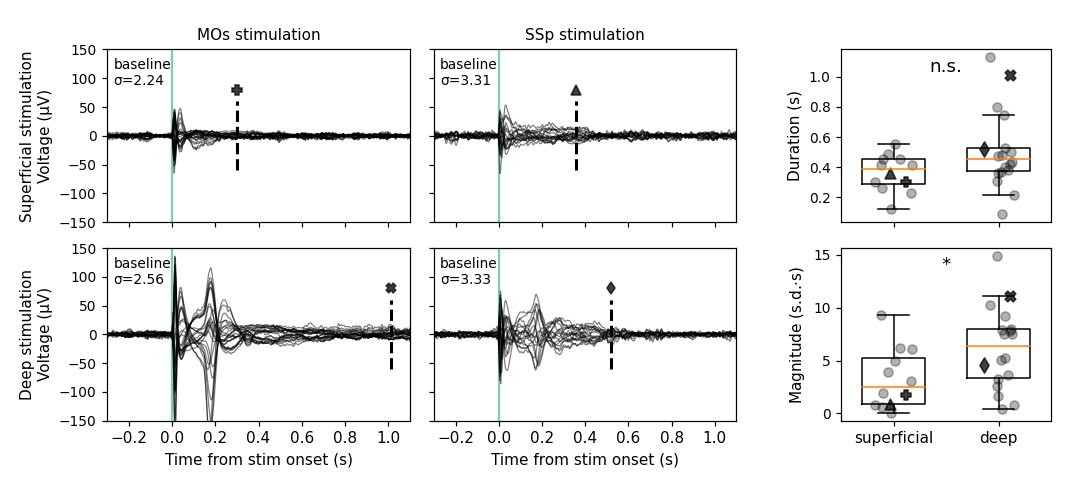

Duration p-value=0.0843
Magnitude p-value=0.0354


In [32]:
plwin = [-0.3, 1.1]
# volt_lim = [-250, 200]
delta = 0.25
plt.rc('ytick', labelsize=9)
gmarks = {'MOs_superficial': 'P', 'MOs_deep': 'X', 'SSp_superficial': '^', 'SSp_deep': 'd'}
pann = {'xy': (0.5, 0.9), 'xycoords': 'axes fraction', 'fontsize': 12, 'ha': 'center', 'va': 'center'}

fig = plt.figure(figsize=(9.75, 4.5))
gs = fig.add_gridspec(
    ncols=2, nrows=1, width_ratios=[3,1], left=0.1, right=0.98, top=0.9, bottom=0.15, wspace=0.25
)
EEGaxs = gs[0].subgridspec(ncols=2, nrows=2, hspace=0.15, wspace=0.08).subplots(sharex=True, sharey=True)
METax = gs[1].subgridspec(ncols=1, nrows=2, hspace=0.15).subplots(sharex=True)

for axi, (group, group_subs) in zip(EEGaxs.flatten('F'), multi_sub_dict.items()):
    ## Plot EEG butterfly plots ##
    EEG_traces = group_subs[example_mice[group]]['EEG_traces']
    GOOD_CHS = group_subs[example_mice[group]]['good_chs']

    timex = EEG_traces[teststate][0]
    traces = np.mean(EEG_traces[teststate][1], axis=2)
    BLstd = np.std(traces[:, GOOD_CHS][timex < 0, :])

    axi.axvline(0, color=c_bgreen, alpha=0.5)
    axi.plot(timex, traces[:, GOOD_CHS], 'k', linewidth=0.8, alpha=0.5)
    axi.annotate(
        'baseline\n\u03c3={:.2f}'.format(BLstd), xy=(0.02, 0.95), xycoords='axes fraction', fontsize=9, ha='left', va='top'
    )
    ## Add vertical line for duration? ##
    example_dur = ERP_metrics['duration'][
        (ERP_metrics['group'] == group) & (ERP_metrics['mouse'] == example_mice[group])
    ].values[0]
    axi.axvline(example_dur, ymin=0.3, ymax=0.7, color='k', linewidth=2, linestyle='dashed')
    axi.plot(example_dur, 80, color='k', linestyle=None, marker=gmarks[group], alpha=0.75)
    
## Set titles ##
EEGaxs[0,0].set_ylim([-150, 150])
EEGaxs[0,0].set_title('MOs stimulation')
EEGaxs[0,1].set_title('SSp stimulation')
EEGaxs[0,0].set_ylabel('Superficial stimulation\nVoltage (\u03bcV)')
EEGaxs[1,0].set_ylabel('Deep stimulation\nVoltage (\u03bcV)')
EEGaxs[1,0].set_xlabel('Time from stim onset (s)')
EEGaxs[1,1].set_xlabel('Time from stim onset (s)')
EEGaxs[0,0].set_xticks(np.arange(timex[0], timex[-1], 0.2))
EEGaxs[0,0].set_xlim(plwin)
    
## Plot metrics ##
group_duration = []
group_magnitude = []
tick_labels = []
for ii, loci in enumerate(['superficial', 'deep']):
    locidf = ERP_metrics[(ERP_metrics['stim_depth'] == loci)]
    exmask = np.array([True if mn in example_mice.values() else False for mn in locidf['mouse'].values])
    xs = np.random.normal(ii, 0.1, len(locidf))
    METax[0].boxplot(locidf['duration'].values, positions=[ii], widths=[0.6], showfliers=False)
    METax[0].scatter(xs[~exmask], locidf['duration'].values[~exmask], c='k', marker='o', alpha=0.3)
    group_duration.append(locidf['duration'].values)
    
    METax[1].boxplot(locidf['magnitude'].values, positions=[ii], widths=[0.6], showfliers=False)
    METax[1].scatter(xs[~exmask], locidf['magnitude'].values[~exmask], c='k', marker='o', alpha=0.3)
    group_magnitude.append(locidf['magnitude'].values)
    
    for indi in np.nonzero(exmask)[0]:
        METax[0].scatter(
            xs[indi], locidf['duration'].values[indi], c='k', marker=gmarks[locidf['group'].values[indi]], s=50, alpha=0.75)
        METax[1].scatter(
            xs[indi], locidf['magnitude'].values[indi], c='k', marker=gmarks[locidf['group'].values[indi]], s=50, alpha=0.75)
            
METax[0].set_ylabel('Duration (s)')
METax[1].set_ylabel('Magnitude (s.d.$\cdot$s)')
METax[1].set_xticks([0,1])
METax[1].set_xticklabels(['superficial', 'deep'])

## Run stats on magnitude and duration ##
## Calculate t-test for unpaired samples (parametric test) ##
tt_duration = stats.ttest_ind(group_duration[0], group_duration[1])
print('Duration p-value={:.4f}'.format(tt_duration[1]))
tt_magnitude = stats.ttest_ind(group_magnitude[0], group_magnitude[1])
print('Magnitude p-value={:.4f}'.format(tt_magnitude[1]))
METax[0].annotate(p_stars(tt_duration[1]), **pann)
METax[1].annotate(p_stars(tt_magnitude[1]), **pann)

## Save ##
figname = 'Fig1DE_ERPmetrics_annot_{}_{}.png'.format(teststate, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

### Print values for each group for paper:

Normality test: Shapiro-Wilk test

In [25]:
for loci in ['superficial', 'deep']:
    print(loci)
    locidf = ERP_metrics[(ERP_metrics['stim_depth'] == loci)]
    for metname in ['duration', 'magnitude']:
        print(' {}'.format(metname))
        metvalues = locidf[metname].values
        swstat, swp = stats.shapiro(metvalues)
        if swp < sigalpha:
            print('  Reject null: the sample does not come from a normal distribution.')
        else:
            print('  Subjects: {:d}, Mean: {:.1f}, SEM: {:.1f}'.format(
                len(metvalues), np.mean(metvalues), np.std(metvalues)/np.sqrt(len(metvalues))))
#             print('  Do not reject null: the sample may come from a normal distribution.')
            
    print('')

superficial
 duration
  Subjects: 12, Mean: 0.4, SEM: 0.0
 magnitude
  Subjects: 12, Mean: 3.3, SEM: 0.8

deep
 duration
  Subjects: 18, Mean: 0.5, SEM: 0.1
 magnitude
  Subjects: 18, Mean: 6.2, SEM: 0.9



## Supplementary figure about ERP spatial extent

<IPython.core.display.Javascript object>


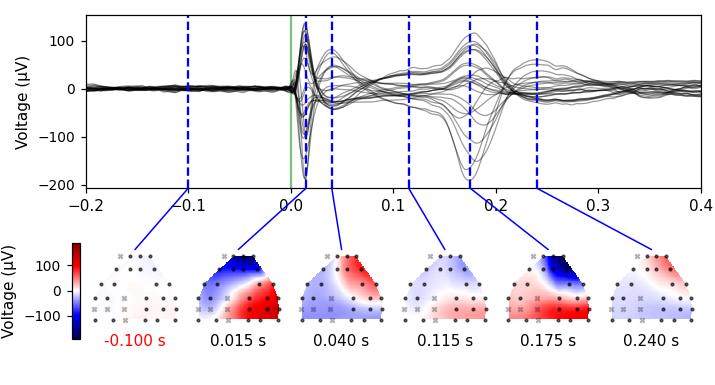

In [34]:
gg = 'MOs_deep'
mm = '571619'
plwin = [-0.2, 0.4]
plot_times = [-0.1, 0.015, 0.04, 0.115, 0.175, 0.24] # [-0.1, 0.015, 0.04, 0.115, 0.175, 0.24]

GOOD_CHS = multi_sub_dict[gg][mm]['good_chs']
BAD_CHS = np.array([x for x in eeg_chs if x not in GOOD_CHS])
timex = multi_sub_dict[gg][mm]['EEG_traces'][teststate][0]
traces = np.mean(multi_sub_dict[gg][mm]['EEG_traces'][teststate][1], axis=2)
vlim = np.max(np.abs(traces[:, GOOD_CHS]))

ml = np.linspace(-5, 5, 100)
ap = np.linspace(-5, 3, 100)
ML, AP = np.meshgrid(ml, ap)

fig = plt.figure(figsize=(6.5, 3.5))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.12, right=0.98, top=0.96, bottom=0.1, height_ratios=[1.5,1], hspace=0.3)
EEGax = fig.add_subplot(gs[0])
interpgs = gs[1].subgridspec(ncols=len(plot_times), nrows=1, wspace=0.05)
axs = [fig.add_subplot(ss) for ss in interpgs]

EEGax.axvline(0, color='g', alpha=0.5)
EEGax.plot(timex, traces[:, GOOD_CHS], 'k', linewidth=0.8, alpha=0.4)
EEGax.set_xlim(plwin)
EEGax.set_ylabel('Voltage (\u03bcV)')

for ax, timei in zip(axs, plot_times):
    EEGax.axvline(timei, color='b', linestyle='dashed')
    if timei < 0:
        fontc = 'r'
    else:
        fontc = 'k'
    
    interp_EEG = interpolate.griddata(
        (EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS]),
        traces[find_nearest_ind(timex, timei), GOOD_CHS], (ML, AP), method='cubic',
    )
    
    cEEG = ax.imshow(
        interp_EEG, cmap='seismic', vmin=-vlim, vmax=vlim, origin='lower', interpolation='none',
        extent=(ml[0], ml[-1], ap[0], ap[-1])
    )
    ax.scatter(
        EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
        c='k', alpha=0.6, marker='o', s=3
    )
    ax.scatter(
        EEGexp.EEG_channel_coordinates['ML'][BAD_CHS], EEGexp.EEG_channel_coordinates['AP'][BAD_CHS],
        c='k', alpha=0.3, marker='x', s=8
    )
#     ax.scatter(0, 0, marker='+', color='k', s=15, alpha=0.3) # bregma marker
    ax.set_xlabel('{:.3f} s'.format(timei), color=fontc)
    ax.set(frame_on=False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ## Make connecting line ##
    con = ConnectionPatch(
        xyA=[timei, EEGax.get_ylim()[0]], xyB=[0.5, 1], coordsA='data', coordsB='axes fraction',
        axesA=EEGax, axesB=ax, color='b'
    )
    ax.add_artist(con)

cbax = fig.add_axes([0.1, 0.12, 0.012, 0.25])
fig.colorbar(cEEG, cax=cbax, ticklocation='left', label='Voltage (\u03bcV)')

## Save ##
figname = 'SuppFig1.1_EEG_spatialinterp.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

## Supplementary figure about ERP metrics

Global field power - from Cohen's book Analyzing Neural Time Series Data, pg 100 - is the standard deviation across chs at all time points

<IPython.core.display.Javascript object>


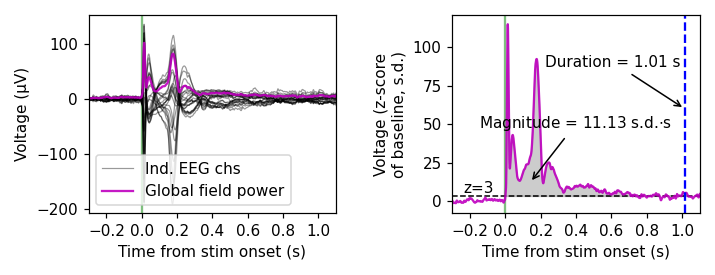

In [18]:
gg = 'MOs_deep'
mm = '571619'
plwin = [-0.3, 1.1]
zlim = 3

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6.5, 2.5), sharex=True)#, sharey=True)
fig.set_tight_layout({'rect': [0, 0, 1, 1], 'pad': 1.0, 'w_pad': 2.5})

GOOD_CHS = multi_sub_dict[gg][mm]['good_chs']
timex = multi_sub_dict[gg][mm]['EEG_traces'][teststate][0]
traces = np.mean(multi_sub_dict[gg][mm]['EEG_traces'][teststate][1], axis=2)
# BLstd = np.std(traces[:, GOOD_CHS][timex < 0, :])

## Plot EEG traces and global field power ##
axs[0].axvline(0, color='g', alpha=0.5)
axs[0].plot(timex, traces[:, GOOD_CHS], 'k', linewidth=0.8, alpha=0.4)

gfpow = np.std(traces[:, GOOD_CHS], axis=1)
axs[0].plot(timex, gfpow, 'm', linewidth=1.5, alpha=0.9)
   
axs[0].set_xticks(np.arange(timex[0], timex[-1], 0.2))
axs[0].set_xlim(plwin)
axs[0].set_ylabel('Voltage (\u03bcV)')
axs[0].set_xlabel('Time from stim onset (s)')
## Add legend ##
lh = [
    Line2D([0],[0], color='k', linewidth=0.8, alpha=0.4, label='Ind. EEG chs'),
    Line2D([0],[0], color='m', linewidth=1.5, alpha=0.9, label='Global field power')
]
axs[0].legend(handles=lh, loc='lower left')

## Plot global field power (z-score)
blmean = np.mean(gfpow[timex < 0])
blstd = np.std(gfpow[timex < 0])
zgfpow = (gfpow - blmean) / blstd
axs[1].axvline(0, color='g', alpha=0.5)
axs[1].axhline(zlim, color='k', linewidth=1, linestyle='dashed')
axs[1].plot(timex, zgfpow, 'm', linewidth=1.5, alpha=0.9)
axs[1].set_ylabel('Voltage (z-score\nof baseline, s.d.)')
axs[1].set_xlabel('Time from stim onset (s)')

zerp = np.where((zgfpow[timex > 0] - zlim) >= 0, (zgfpow[timex > 0] - zlim), 0.)
auc = integrate.simps(zerp, timex[timex > 0], axis=0, even='last')
resp_dur = np.sum(zgfpow[timex > 0] > zlim) / multi_sub_dict[gg][mm]['exp'].ephys_params['EEG']['sample_rate']
axs[1].axvline(resp_dur, color='b', linewidth=1.5, linestyle='dashed')
axs[1].fill_between(x=timex[timex > 0], y1=zgfpow[timex > 0], y2=zlim, where=zgfpow[timex > 0] > zlim, color='k', alpha=0.2)

## Annotate it ##
axs[1].annotate(
    'Duration = {:.2f} s'.format(resp_dur), xy=(resp_dur, 60), xycoords='data', xytext=(0.65, 0.8), textcoords='axes fraction',
    arrowprops=dict(arrowstyle="->"), ha='center', va='top'
)
axs[1].annotate(
    'Magnitude = {:.2f} s.d.$\cdot$s'.format(auc), xy=(0.14, 12), xycoords='data', xytext=(0.5, 0.5), textcoords='axes fraction',
    arrowprops=dict(arrowstyle="->"), ha='center', va='top'
)
axs[1].annotate('z=3', xy=(-0.15, 3), xycoords='data', ha='center', va='bottom')

## Save ##
figname = 'SuppFig1.2_GFP_EEGdur.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

### Plot MO vs. SS for CK

In [85]:
ERP_metrics.head()

,group,mouse,stim_cortex,stim_depth,num_chs,num_trials,duration,magnitude
0,MOs_superficial,521885,MO,superficial,17,60,0.4844,3.876909
1,MOs_superficial,521886,MO,superficial,20,99,0.4132,6.092137
2,MOs_superficial,521887,MO,superficial,21,199,0.4156,9.352101
3,MOs_superficial,543393,MO,superficial,24,300,0.5568,4.939726
4,MOs_superficial,543394,MO,superficial,21,300,0.2296,3.047812


<IPython.core.display.Javascript object>


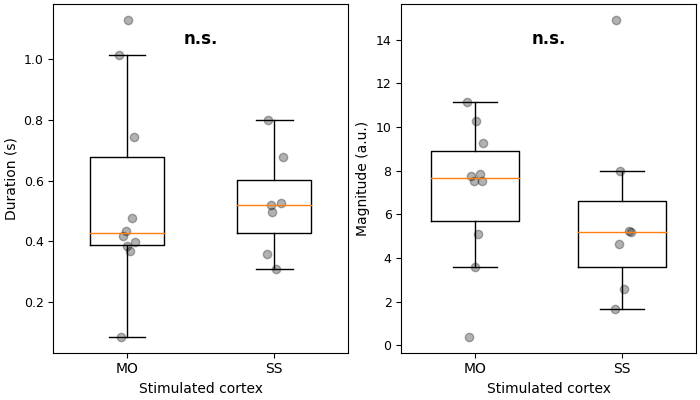

Duration p-value=0.89215
Magnitude p-value=0.58933


In [96]:
valconst = 'stim_depth'
plotconst = 'deep'
valcomp = 'stim_cortex'
plotcomp = ['MO', 'SS']
pann = {'xy': (0.5, 0.9), 'xycoords': 'axes fraction', 'fontsize': 12, 'fontweight': 'bold', 'ha': 'center', 'va': 'center'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 4), sharex=True, constrained_layout=True)

group_duration = []
group_magnitude = []
for ii, loci in enumerate(plotcomp):
    locidf = ERP_metrics[(ERP_metrics[valcomp] == loci) & (ERP_metrics[valconst] == plotconst)]
    xs = np.random.normal(ii, 0.05, len(locidf))
    axs[0].boxplot(locidf['duration'].values, positions=[ii], widths=[0.5], showfliers=False)
    axs[0].scatter(xs, locidf['duration'].values, c='k', marker='o', alpha=0.3)
    group_duration.append(locidf['duration'].values)
    
    axs[1].boxplot(locidf['magnitude'].values, positions=[ii], widths=[0.6], showfliers=False)
    axs[1].scatter(xs, locidf['magnitude'].values, c='k', marker='o', alpha=0.3)
    group_magnitude.append(locidf['magnitude'].values)
    

            
axs[0].set_ylabel('Duration (s)')
axs[0].set_xlabel('Stimulated cortex')
axs[1].set_ylabel('Magnitude (a.u.)')
axs[1].set_xlabel('Stimulated cortex')
axs[1].set_xticks([0,1])
axs[1].set_xticklabels(plotcomp)

## Run stats on magnitude and duration ##
## Calculate t-test for unpaired samples (parametric test) ##
tt_duration = stats.ttest_ind(group_duration[0], group_duration[1])
print('Duration p-value={:.5f}'.format(tt_duration[1]))
tt_magnitude = stats.ttest_ind(group_magnitude[0], group_magnitude[1])
print('Magnitude p-value={:.5f}'.format(tt_magnitude[1]))
axs[0].annotate(p_stars(tt_duration[1]), **pann)
axs[1].annotate(p_stars(tt_magnitude[1]), **pann)

## Save ##
figname = 'COMPARE_MO-SS_{}_{}.png'.format(teststate, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Plot fig 1D-E for SAC meeting

## All normality tests

Normality test: D'Agostino's K-squared test

Normality test: Anderson-Darling test

Normality test: Kolmogorov-Smirnov test